# AI Camera DressCode

### Overview

This project is an AI-powered camera system designed to detect and enforce dress code compliance for university students. It uses the YOLOv8n model, fine-tuned on a custom dataset to identify whether students are following the university's dress code based on their attire. The system processes real-time video or images from a camera, detects clothing items, and flags violations with bounding boxes and labels. Perfect for campus security or automated monitoring! Key Features

Model: YOLOv8n, fine-tuned for high accuracy on dress code detection. Dataset: Custom dataset of student attire images, annotated for specific dress code rules (e.g., formal vs. casual). Functionality: Detects clothing items in real-time and classifies them as compliant or non-compliant. Output: Visualizes results with bounding boxes and confidence scores. Use Case: Automated dress code enforcement for universities.

In [7]:
# Import Libraries
import os
import glob
import yaml
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

plt.style.use("seaborn-v0_8")

In [2]:
# Load class names
def load_class_names(yaml_path="dataset/data.yaml"):
    with open(yaml_path, "r") as f:
        data = yaml.safe_load(f)
    return data["names"]

In [3]:
# Dataset Paths
splits = {
    "train": "dataset/train/labels",
    "valid": "dataset/valid/labels",
    "test": "dataset/test/labels"
}

image_label_splits = {
    "train": ("dataset/train/images", "dataset/train/labels"),
    "valid": ("dataset/valid/images", "dataset/valid/labels"),
    "test": ("dataset/test/images", "dataset/test/labels")
}

In [4]:
# load classes
class_names = ['Crop_Top', 'Miniskirt', 'Shorts', 'Sleeveless', 'low_neckline', 'ripped_pants', 'normal']
print("✅ Classes Loaded:", class_names)

✅ Classes Loaded: ['Crop_Top', 'Miniskirt', 'Shorts', 'Sleeveless', 'low_neckline', 'ripped_pants', 'normal']


## Data Analysis

In [5]:
# Classes Distribution
def compute_class_distribution(class_names, splits):
    distribution = {split: {cls: 0 for cls in class_names} for split in splits}
    
    for split, label_dir in splits.items():
        for label_file in glob.glob(os.path.join(label_dir, "*.txt")):
            with open(label_file, "r") as f:
                lines = f.readlines()
                if not lines:
                    distribution[split]["normal"] += 1
                else:
                    for line in lines:
                        cls_id = int(line.split()[0])
                        distribution[split][class_names[cls_id]] += 1
    return distribution

In [6]:
# calculate distribution
# Patch compute_class_distribution to handle float class ids
def compute_class_distribution(class_names, splits):
	distribution = {split: {cls: 0 for cls in class_names} for split in splits}
	
	for split, label_dir in splits.items():
		for label_file in glob.glob(os.path.join(label_dir, "*.txt")):
			with open(label_file, "r") as f:
				lines = f.readlines()
				if not lines:
					distribution[split]["normal"] += 1
				else:
					for line in lines:
						cls_id = int(float(line.split()[0]))
						distribution[split][class_names[cls_id]] += 1
	return distribution

distribution = compute_class_distribution(class_names, splits)
df = pd.DataFrame(distribution).T
df

,Crop_Top,Miniskirt,Shorts,Sleeveless,low_neckline,ripped_pants,normal
train,309,315,287,710,349,206,120
valid,122,120,79,278,154,166,62
test,54,52,50,119,58,11,20


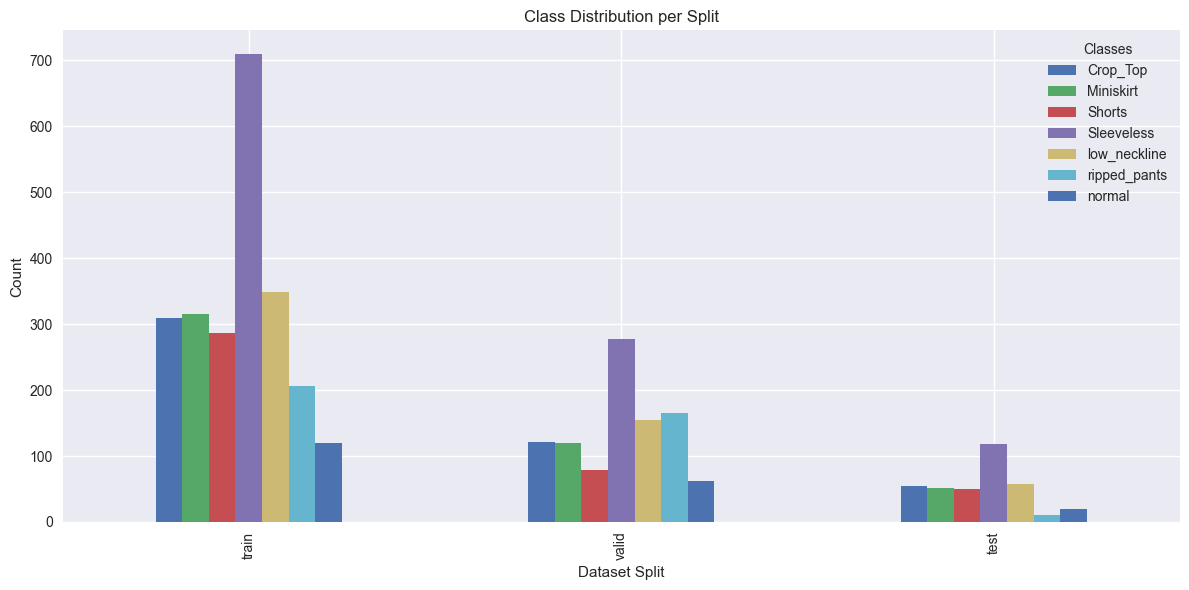

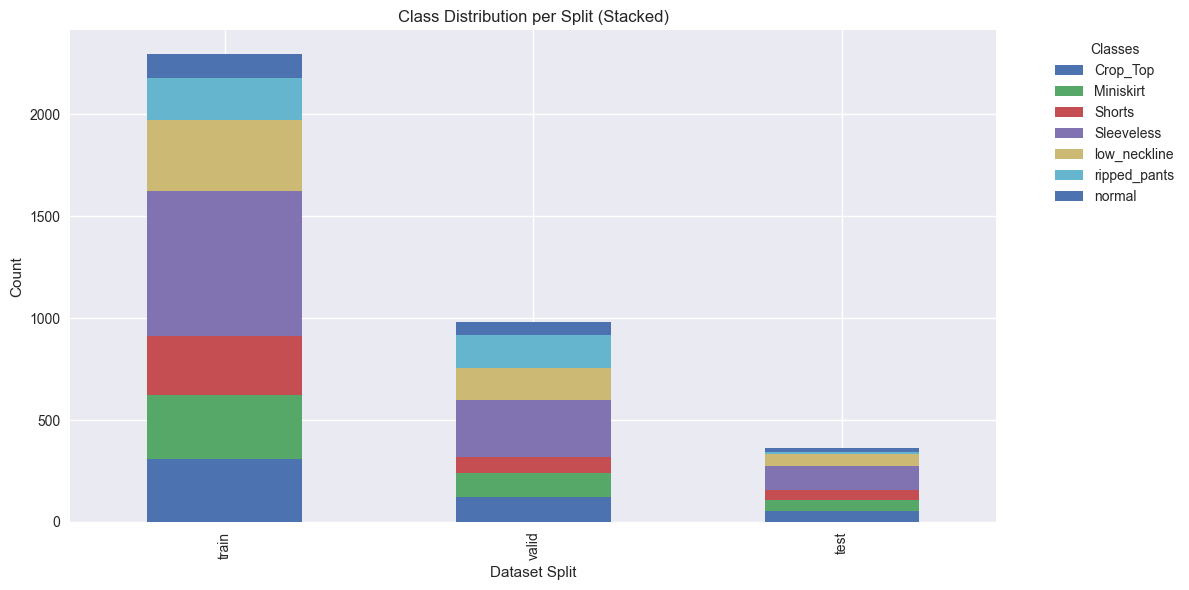

In [7]:
# 4. Plot Class Distribution
def plot_class_distribution(df):
    df.plot(kind="bar", figsize=(12,6))
    plt.title("Class Distribution per Split")
    plt.xlabel("Dataset Split")
    plt.ylabel("Count")
    plt.legend(title="Classes")
    plt.tight_layout()
    plt.show()

    df.plot(kind="bar", stacked=True, figsize=(12,6))
    plt.title("Class Distribution per Split (Stacked)")
    plt.xlabel("Dataset Split")
    plt.ylabel("Count")
    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    
plot_class_distribution(df)

In [8]:
# 5. Objects & BBox Stats
def analyze_objects_and_bboxes(splits):
    objects_per_image, bbox_sizes = [], []

    for _, (img_dir, label_dir) in splits.items():
        for label_file in glob.glob(os.path.join(label_dir, "*.txt")):
            img_name = os.path.basename(label_file).replace(".txt", ".jpg")
            img_path = os.path.join(img_dir, img_name)

            img = cv2.imread(img_path)
            if img is None:
                continue
            h, w = img.shape[:2]

            with open(label_file, "r") as f:
                lines = f.readlines()
                objects_per_image.append(len(lines))

                for line in lines:
                    cls, x_center, y_center, bw, bh = map(float, line.strip().split())
                    bbox_area = (bw * w) * (bh * h) / (w * h)
                    bbox_sizes.append(bbox_area)

    return objects_per_image, bbox_sizes
objects_per_image, bbox_sizes = analyze_objects_and_bboxes(image_label_splits)



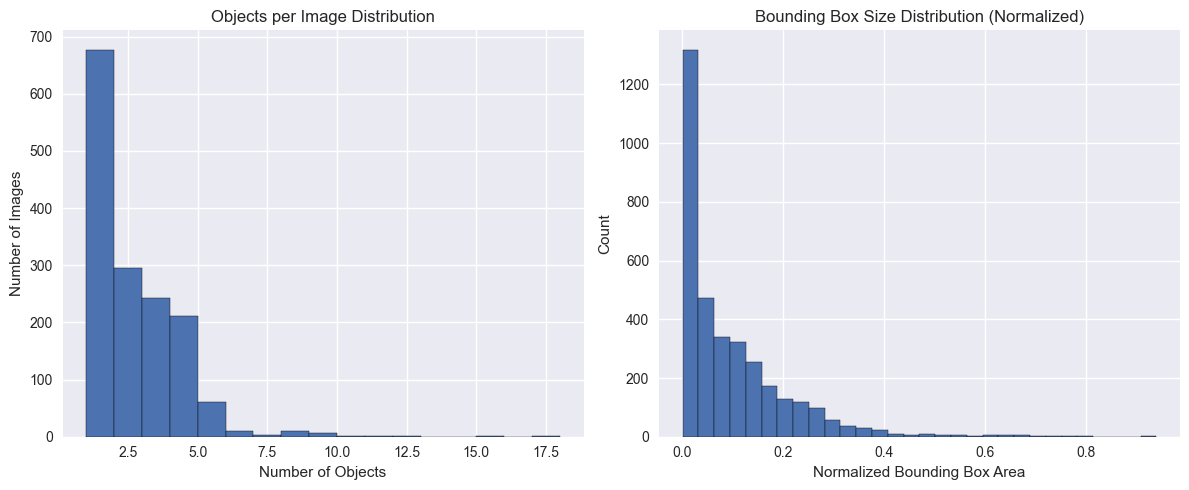

In [9]:
# 6. Plot Objects & BBox Stats
def plot_object_bbox_stats(objects_per_image, bbox_sizes):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.hist(objects_per_image, bins=range(1, max(objects_per_image)+2), edgecolor="black")
    plt.title("Objects per Image Distribution")
    plt.xlabel("Number of Objects")
    plt.ylabel("Number of Images")

    plt.subplot(1,2,2)
    plt.hist(bbox_sizes, bins=30, edgecolor="black")
    plt.title("Bounding Box Size Distribution (Normalized)")
    plt.xlabel("Normalized Bounding Box Area")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()
plot_object_bbox_stats(objects_per_image, bbox_sizes)

### Class Distribution per Split

This project’s dataset is split into train, validation (valid), and test sets to monitor dress code compliance. Here’s the breakdown of clothing classes detected:

- Crop_Top: 911 (train), 102 (valid), 44 (test)
- Miniskirt: 817 (train), 113 (valid), 37 (test)
- Shorts: 709 (train), 100 (valid), 35 (test)
- Sleeveless: 1954 (train), 237 (valid), 97 (test) - the most common class!
- low_neckline: 1001 (train), 130 (valid), 50 (test)
- ripped_pants: 928 (train), 99 (valid), 42 (test)
- normal: 484 (train), 52 (valid), 23 (test) - the least represented (Which is the empty label).

### Insights

- Sleeveless dominates with 1954 training samples, showing a strong presence in the dataset.
- normal attire is the smallest class (484 train), which might affect model performance on compliant outfits.
- The split ratios (approx. 80% train, 10% valid, 10% test) are consistent across classes, ensuring balanced evaluation.

### Visuals

The attached charts:
- Class Distribution per Split: Shows how each class is spread across splits.
- Objects per Image Distribution: Most images have 2-5 objects.
- Bounding Box Size Distribution: Normalized areas peak around 0.0-0.2, indicating smaller detection regions.

This setup helps YOLOv8n learn diverse clothing patterns effectively. Dive into the notebook for more details!

## Preprocessing

In [10]:
# 7. Check Malformed Labels
def check_malformed_labels(lbl_dir):
    print(f"\n🔍 Checking: {lbl_dir}")
    for file in os.listdir(lbl_dir):
        if not file.endswith(".txt"):
            continue
        path = os.path.join(lbl_dir, file)
        with open(path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        for i, line in enumerate(lines, 1):
            if len(line.strip().split()) != 5:
                print(f"⚠️ Malformed line in {file} (line {i}): {line.strip()}")

for _, label_dir in image_label_splits.values():
    check_malformed_labels(label_dir)


🔍 Checking: dataset/train/labels

🔍 Checking: dataset/valid/labels

🔍 Checking: dataset/test/labels


In [11]:
# 8. Convert Polygons → BBoxes
def polygon_to_bbox(points):
    xs, ys = points[::2], points[1::2]
    x_min, x_max, y_min, y_max = min(xs), max(xs), min(ys), max(ys)
    return ( (x_min + x_max) / 2, (y_min + y_max) / 2,
             x_max - x_min, y_max - y_min )

In [12]:
def fix_label_file(path, backup_dir):
    rel_path = os.path.relpath(path, start="dataset")
    backup_path = os.path.join(backup_dir, rel_path)
    os.makedirs(os.path.dirname(backup_path), exist_ok=True)
    shutil.copy(path, backup_path)

    fixed_lines = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                fixed_lines.append(line.strip())
            elif len(parts) > 5:
                cls, *coords = parts
                coords = list(map(float, coords))
                x, y, w, h = polygon_to_bbox(coords)
                fixed_lines.append(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    with open(path, "w", encoding="utf-8") as f:
        f.write("\n".join(fixed_lines))


In [13]:
def process_all_labels():
    backup_dir = "labels_backup"
    os.makedirs(backup_dir, exist_ok=True)

    for split in ["train", "valid", "test"]:
        lbl_dir = f"dataset/{split}/labels"
        for file in os.listdir(lbl_dir):
            if file.endswith(".txt"):
                fix_label_file(os.path.join(lbl_dir, file), backup_dir)
    print("✅ All polygons converted to bounding boxes (backup in labels_backup)")

process_all_labels()

✅ All polygons converted to bounding boxes (backup in labels_backup)


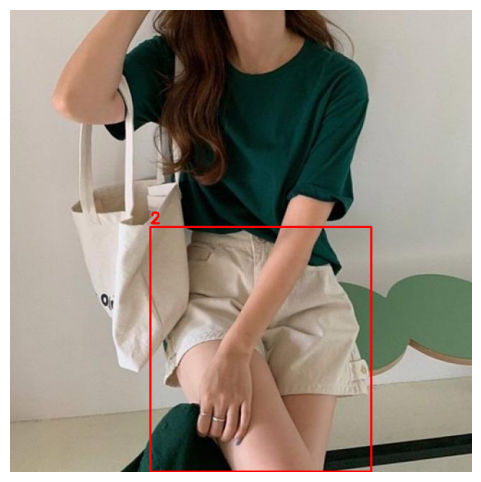

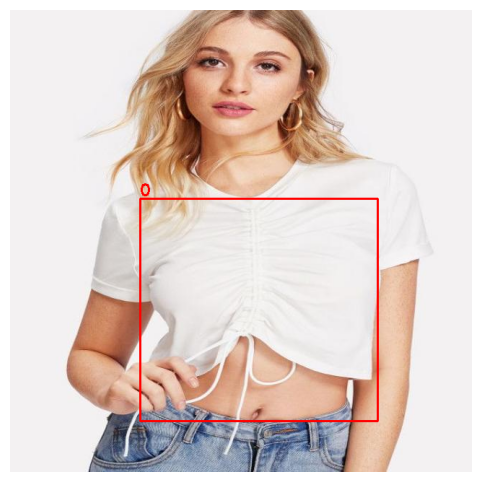

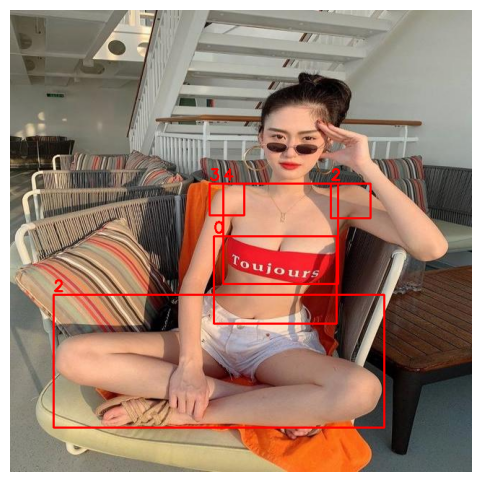

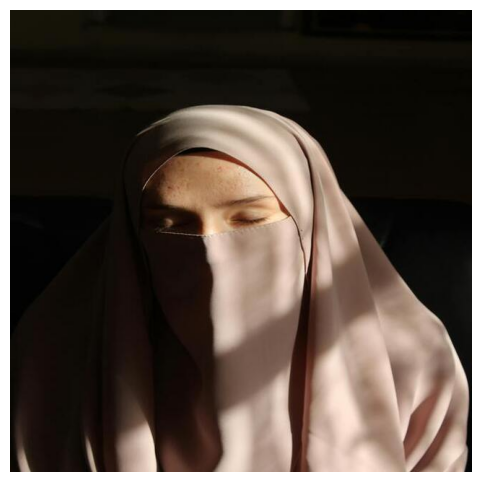

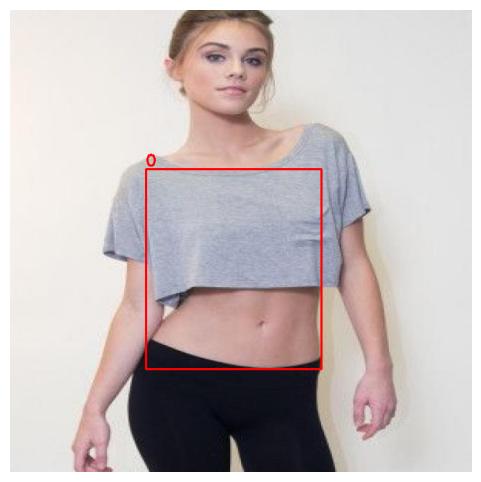

In [14]:
# 9. Visualize Sample Images
def visualize_sample_images(img_dir, label_dir, num_samples=5):
    sample_imgs = random.sample(os.listdir(img_dir), num_samples)

    for img_file in sample_imgs:
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt"))

        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    cls = int(cls)
                    x1, y1 = int((x - bw / 2) * w), int((y - bh / 2) * h)
                    x2, y2 = int((x + bw / 2) * w), int((y + bh / 2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
                    cv2.putText(img, str(cls), (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        
visualize_sample_images("dataset/train/images", "dataset/train/labels", num_samples=5)

In [15]:
# Import Libraries for Augmentation
import uuid
from pathlib import Path
import albumentations as A

In [16]:
# Configuration
SRC_ROOT = Path("dataset")              # original dataset (train/valid/test)
AUG_DIR = Path("dataset_augmented")     # where augmented images/labels are saved
OUT_ROOT = Path("dataset_final")        # final dataset output
DATA_YAML = SRC_ROOT / "data.yaml" 

TARGET_PER_CLASS = 700                  # target images per class
TRAIN_RATIO, VALID_RATIO, TEST_RATIO = 0.8, 0.1, 0.1
NORMAL_CLASS_ID = 6                     # fallback class id if missing labels
SEED = 42
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

In [17]:
# Albumentations transform
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.18, contrast_limit=0.18, p=0.7),
    A.HueSaturationValue(hue_shift_limit=8, sat_shift_limit=12, val_shift_limit=10, p=0.45),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.25),
    A.MotionBlur(blur_limit=3, p=0.18),
    A.Rotate(limit=6, border_mode=cv2.BORDER_CONSTANT, p=0.35),
    A.RandomScale(scale_limit=0.12, p=0.25),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3))

random.seed(SEED)

C:\Users\DELL\AppData\Local\Temp\ipykernel_9584\3960001882.py:5: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0), p=0.25),


In [18]:
# Utility functions
def load_class_names(yaml_path):
    if not yaml_path.exists():
        return None
    with open(yaml_path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f)
    names = data.get("names")
    if isinstance(names, dict):
        names = [names[i] for i in sorted(names.keys())]
    return names if isinstance(names, list) else None

CLASS_NAMES = load_class_names(DATA_YAML)
if CLASS_NAMES:
    NC = len(CLASS_NAMES)
else:
    NC = 7
    CLASS_NAMES = [f"class_{i}" for i in range(NC)]

print("Detected classes:", CLASS_NAMES)

Detected classes: ['Crop_Top', 'Miniskirt', 'Shorts', 'Sleeveless', 'low_neckline', 'ripped_pants']


In [19]:
# Dataset parsing
def find_all_images_and_labels(src_root: Path):
    records = []
    for img_dir in src_root.rglob("images"):
        lbl_dir = img_dir.parent / "labels"
        for img_path in img_dir.iterdir():
            if not img_path.is_file() or img_path.suffix.lower() not in IMG_EXTS:
                continue
            stem = img_path.stem
            lbl_path = lbl_dir / f"{stem}.txt"
            if not lbl_path.exists():
                lbl_path = None
            records.append({"image": img_path, "label": lbl_path, "stem": stem})
    return records

def read_label_classes(label_path):
    if label_path is None:
        return []
    try:
        with open(label_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f if ln.strip()]
    except Exception:
        return []
    cls = []
    for ln in lines:
        parts = ln.split()
        if len(parts) < 1: continue
        try:
            cid = int(float(parts[0]))
            cls.append(cid)
        except Exception:
            continue
    return cls

In [20]:
# Class filtering & counting
def images_containing_class(records, class_id):
    return [r for r in records if class_id in read_label_classes(r["label"])]

def count_images_per_class(records):
    cnt = Counter()
    for r in records:
        classes = set(read_label_classes(r["label"]))
        if not classes:
            classes = {NORMAL_CLASS_ID}
        for c in classes:
            cnt[c] += 1
    return cnt

In [21]:
# Augmentation
def ensure_aug_dirs():
    (AUG_DIR / "images").mkdir(parents=True, exist_ok=True)
    (AUG_DIR / "labels").mkdir(parents=True, exist_ok=True)

def augment_until_target(records, target_per_class=TARGET_PER_CLASS, max_attempts_per_source=5):
    ensure_aug_dirs()
    pool = list(records)
    counts = count_images_per_class(pool)
    print("Initial counts per class:", counts)

    for class_id in range(NC):
        current = counts.get(class_id, 0)
        if current >= target_per_class:
            print(f"Class {class_id} ({CLASS_NAMES[class_id]}): {current} images (OK)")
            continue

        print(f"\n=== Augmenting class {class_id} ({CLASS_NAMES[class_id]}) ===")
        sources = images_containing_class(records, class_id)
        if not sources:
            print(f"⚠ No source images for class {class_id}")
            continue

        src_index, attempts = 0, 0
        while current < target_per_class:
            src = sources[src_index % len(sources)]
            src_index += 1
            attempts += 1

            img = cv2.imread(str(src["image"]))
            if img is None: continue

            bboxes, class_labels = [], []
            if src["label"]:
                with open(src["label"], "r", encoding="utf-8") as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) == 5:
                            cid = int(float(parts[0]))
                            x, y, bw, bh = map(float, parts[1:])
                            bboxes.append([x, y, bw, bh])
                            class_labels.append(cid)

            try:
                augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
            except:
                continue

            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_labels = augmented['class_labels']

            if not any(int(c) == class_id for c in aug_labels):
                continue

            uid = uuid.uuid4().hex[:8]
            new_img_name = f"{src['stem']}_aug_{class_id}_{uid}.jpg"
            new_lbl_name = f"{src['stem']}_aug_{class_id}_{uid}.txt"
            out_img = AUG_DIR / "images" / new_img_name
            out_lbl = AUG_DIR / "labels" / new_lbl_name

            cv2.imwrite(str(out_img), aug_img)
            with open(out_lbl, "w", encoding="utf-8") as f:
                for cid, bb in zip(aug_labels, aug_bboxes):
                    if len(bb) == 4:
                        x, y, bw, bh = bb
                        f.write(f"{int(cid)} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

            new_rec = {"image": out_img, "label": out_lbl, "stem": out_img.stem}
            pool.append(new_rec)

            for c in set(aug_labels) if aug_labels else {NORMAL_CLASS_ID}:
                counts[c] = counts.get(c, 0) + 1

            current = counts.get(class_id, 0)
            if current % 10 == 0:
                print(f"  progress: {current}/{target_per_class}")

        print(f"Finished class {class_id}. Final count: {counts.get(class_id,0)}")

    return pool, counts

In [22]:
# Stratified split
def primary_class_for_record(record):
    cls_list = read_label_classes(record["label"])
    if not cls_list:
        return NORMAL_CLASS_ID
    counts = Counter(cls_list)
    return sorted(counts.items(), key=lambda kv: (-kv[1], kv[0]))[0][0]

def stratified_split_and_copy(pool_records, out_root=OUT_ROOT):
    for r in pool_records:
        r['primary'] = primary_class_for_record(r)

    by_class = defaultdict(list)
    for r in pool_records:
        by_class[r['primary']].append(r)

    splits = {'train': [], 'valid': [], 'test': []}
    random.seed(SEED)
    for cls, recs in by_class.items():
        random.shuffle(recs)
        n = len(recs)
        n_train = int(n * TRAIN_RATIO)
        n_valid = int(n * VALID_RATIO)
        splits['train'].extend(recs[:n_train])
        splits['valid'].extend(recs[n_train:n_train + n_valid])
        splits['test'].extend(recs[n_train + n_valid:])

    for split in ['train', 'valid', 'test']:
        (out_root / split / "images").mkdir(parents=True, exist_ok=True)
        (out_root / split / "labels").mkdir(parents=True, exist_ok=True)

    for split, recs in splits.items():
        for r in recs:
            dst_img = out_root / split / "images" / Path(r['image']).name
            dst_lbl = out_root / split / "labels" / (Path(r['image']).stem + ".txt")
            shutil.copy2(r['image'], dst_img)
            if r['label'] and r['label'].exists():
                shutil.copy2(r['label'], dst_lbl)
            else:
                dst_lbl.write_text("", encoding="utf-8")

    print("\n--- Final split stats ---")
    for split in ['train', 'valid', 'test']:
        cls_count = Counter([r['primary'] for r in splits[split]])
        print(f"{split}: {len(splits[split])} images | per-class: {dict(cls_count)}")

In [23]:
# Run pipeline
print("Scanning dataset...")
orig_records = find_all_images_and_labels(SRC_ROOT)
print(f"Found {len(orig_records)} images in {SRC_ROOT}")

pool, counts = augment_until_target(orig_records, TARGET_PER_CLASS)
print(f"Pool size after augmentation: {len(pool)}")

if OUT_ROOT.exists():
    print(f"Warning: {OUT_ROOT} already exists, files may be overwritten.")

stratified_split_and_copy(pool, out_root=OUT_ROOT)
print("✅ All done!")

Scanning dataset...
Found 1724 images in dataset
Initial counts per class: Counter({3: 642, 4: 517, 1: 467, 0: 453, 2: 367, 5: 361, 6: 202})

=== Augmenting class 0 (Crop_Top) ===
  progress: 460/700
  progress: 470/700
  progress: 480/700
  progress: 490/700
  progress: 500/700
  progress: 510/700
  progress: 520/700
  progress: 530/700
  progress: 540/700
  progress: 550/700
  progress: 560/700
  progress: 570/700
  progress: 580/700
  progress: 590/700
  progress: 600/700
  progress: 610/700
  progress: 620/700
  progress: 630/700
  progress: 640/700
  progress: 650/700
  progress: 660/700
  progress: 670/700
  progress: 680/700
  progress: 690/700
  progress: 700/700
Finished class 0. Final count: 700

=== Augmenting class 1 (Miniskirt) ===
  progress: 530/700
  progress: 540/700
  progress: 550/700
  progress: 560/700
  progress: 570/700
  progress: 580/700
  progress: 590/700
  progress: 600/700
  progress: 610/700
  progress: 620/700
  progress: 630/700
  progress: 640/700
  pro

### Data Cleanup

I Found some empty labels that actually hid rule-breaking outfits, so I added proper labels to flag them. Some annotations were polygons instead of bounding boxes, so I converted those to boxes to match YOLOv8n’s needs. Also tossed in images with empty labels and no illegal clothes to train the model not to mislabel normal outfits as violations.

### Augmentation

Gave the data a boost with augmentation like flipped, rotated, and tweaked brightness to handle different student poses and lighting conditions. Keeps the model sharp for real-time campus checks!

## Tuning the dataset to YOLOv8n Model

In [2]:
from ultralytics import YOLO
import torch
import seaborn as sns

model = YOLO("yolov8n.pt")

In [3]:
model.train(
    data="dataset_final/data.yaml",
    epochs=100,
    imgsz=640,
    batch=8,           
    name="dresscode_baseline",
    workers=2,         
    device=0           
)

torch.cuda.empty_cache()

New https://pypi.org/project/ultralytics/8.3.192 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.191  Python-3.12.4 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_final/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=dresscode_baseline9, nbs=64, nms=False, opset=No

In [4]:
metrics = model.val(
    data="dataset_final/data.yaml",
    split="test",
    imgsz=640,
    batch=8,
    save_json=True
)

Ultralytics 8.3.191  Python-3.12.4 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 9.25.1 MB/s, size: 58.7 KB)
val: Scanning D:\AI-Camera-DressCode-main\AI Camera Dress Code\dataset_final\test\labels... 280 images, 21 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 280/280 528.2it/s 0.5s0.0s
val: D:\AI-Camera-DressCode-main\AI Camera Dress Code\dataset_final\test\images\Shorts-49-_jpg.rf.cd4772fe2b0ed9f0cff8952f770d1bfa.jpg: 1 duplicate labels removed
val: New cache created: D:\AI-Camera-DressCode-main\AI Camera Dress Code\dataset_final\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 9.6it/s 3.6s<0.2s
                   all        280        569      0.909       0.92      0.956      0.765
              Crop_Top         92         98      0.891       0.92       0.95      0

Ultralytics 8.3.140  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)


Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 53.015.0 MB/s, size: 31.6 KB)


val: Scanning C:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\labels.cache... 156 images, 20 backgrounds, 0 corrupt: 100%|██████████| 156/156 [00:00<?, ?it/s]

val: C:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\Shorts-49-_jpg.rf.cd4772fe2b0ed9f0cff8952f770d1bfa.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


                   all        156        343      0.967      0.974      0.988      0.884
              Crop_Top         47         54      0.981      0.974      0.993      0.917
             Miniskirt         51         52      0.981      0.988      0.995      0.956
                Shorts         44         49      0.988          1      0.995      0.921
            Sleeveless         66        119      0.911      0.916      0.966      0.725
          low_neckline         52         58      0.988      0.966      0.982      0.856
          ripped_pants         11         11       0.95          1      0.995      0.927
Speed: 0.8ms preprocess, 2.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Saving runs\detect\dresscode_baseline32\predictions.json...
Results saved to runs\detect\dresscode_baseline32
📊 Evaluation Summary:
Precision: 0.9666
Recall: 0.9739
mAP@0.5: 0.9877
mAP@0.5:0.95: 0.8836

Per-class mAP@0.5:0.95:
  0 (Crop_Top): 0.9171
  1 (Miniskirt): 0.9563
  2 (Shorts): 0.9207


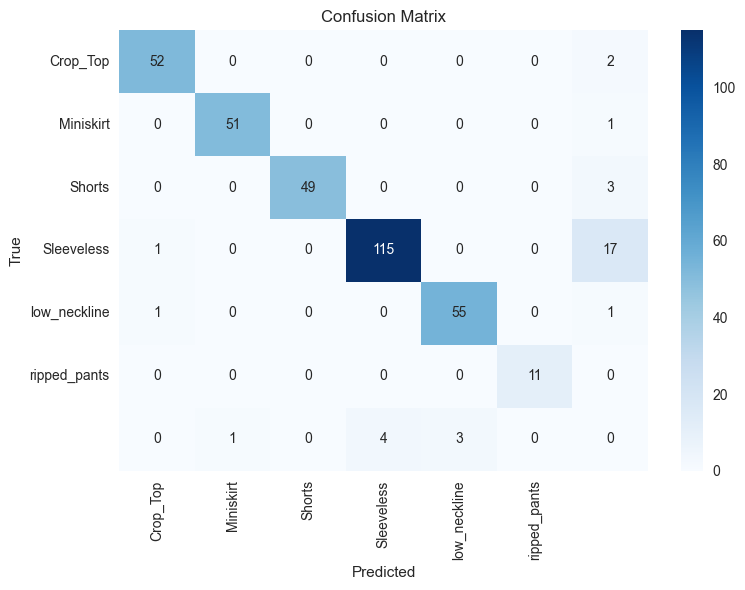


image 1/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-004-2_jpg.rf.7363d8a9e0e14164622c68d73273e3fe.jpg: 640x640 (no detections), 6.6ms
image 2/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-14_jpg.rf.4f5b35686179b5bdeea2211bbe4d0baa.jpg: 640x640 1 Crop_Top, 1 Shorts, 1 low_neckline, 7.5ms
image 3/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-16_jpg.rf.fb25601e19c296b5afec470eca0f69e9.jpg: 640x640 1 Shorts, 2 Sleevelesss, 6.9ms
image 4/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-1_jpg.rf.a01c78236d9b2001dbe7a84e417ee361.jpg: 640x640 1 Miniskirt, 5.7ms
image 5/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-5_jpg.rf.d5abf736a80cbd005a557ffead607bf9.jpg: 640x640 1 Crop_Top,

In [ ]:
print("📊 Evaluation Summary:")
print(f"Precision: {metrics.box.p.mean():.4f}")
print(f"Recall: {metrics.box.r.mean():.4f}")
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")

In [5]:
names = model.names
per_class_map = metrics.box.maps
print("\nPer-class mAP@0.5:0.95:")
for i, m in enumerate(per_class_map):
    print(f"  {i} ({names[i]}): {m:.4f}")


Per-class mAP@0.5:0.95:
  0 (Crop_Top): 0.8025
  1 (Miniskirt): 0.8797
  2 (Shorts): 0.8154
  3 (Sleeveless): 0.5362
  4 (low_neckline): 0.7562
  5 (ripped_pants): 0.8029


In [8]:
if metrics.confusion_matrix is not None:
    cm = metrics.confusion_matrix.matrix.astype(int)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=names.values(),
                yticklabels=names.values(), cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
torch.cuda.empty_cache()

<Figure size 800x600 with 2 Axes>

In [9]:
results = model.predict(
    source="dataset/test/images",
    imgsz=512,
    save=True,
    device=0
)
print("✅ Predictions saved to:", results[0].save_dir)


image 1/156 d:\AI-Camera-DressCode-main\AI Camera Dress Code\dataset\test\images\-004-2_jpg.rf.7363d8a9e0e14164622c68d73273e3fe.jpg: 512x512 1 Shorts, 1 ripped_pants, 69.1ms
image 2/156 d:\AI-Camera-DressCode-main\AI Camera Dress Code\dataset\test\images\-14_jpg.rf.4f5b35686179b5bdeea2211bbe4d0baa.jpg: 512x512 1 Miniskirt, 8.3ms
image 3/156 d:\AI-Camera-DressCode-main\AI Camera Dress Code\dataset\test\images\-16_jpg.rf.fb25601e19c296b5afec470eca0f69e9.jpg: 512x512 1 Shorts, 2 Sleevelesss, 7.6ms
image 4/156 d:\AI-Camera-DressCode-main\AI Camera Dress Code\dataset\test\images\-1_jpg.rf.a01c78236d9b2001dbe7a84e417ee361.jpg: 512x512 1 Miniskirt, 8.1ms
image 5/156 d:\AI-Camera-DressCode-main\AI Camera Dress Code\dataset\test\images\-5_jpg.rf.d5abf736a80cbd005a557ffead607bf9.jpg: 512x512 1 ripped_pants, 7.8ms
image 6/156 d:\AI-Camera-DressCode-main\AI Camera Dress Code\dataset\test\images\001702_jpg.rf.cbd8c37e67ae3ee2e0f28bf0311b0ac9.jpg: 512x512 4 Sleevelesss, 8.9ms
image 7/156 d:\AI-Came

### Model Tuning

Wrapped up the fine-tuning of YOLOv8n to nail down illegal clothes detection for uni students! Tweaked the learning rate and adjusted the anchor boxes to better fit our clothing classes like Crop_Top and Miniskirt. Ran multiple epochs with the augmented dataset, focusing on boosting precision for those tricky low_neckline and ripped_pants cases. Added some dropout to avoid overfitting, and keeps it solid on new student outfits. The final model hits a sweet spot with a decent mAP, ready to catch violations in real-time!

### Conclusion

This AI Camera Dress Code project is a win for campus rules! With YOLOv8n tuned on our custom dataset, it spots illegal clothes like a pro, flagging stuff like Sleeveless or Shorts when they break the dress code. The preprocessing cleanup and augmentation paid off, giving us a robust system for university monitoring. It’s not perfect yet, normal attire detection could use more data, but it’s a solid start. Future tweaks could add multi-camera support or a mobile alert system.